<h1>Intro to Expectation-Maximization with showing a change of parameters with Python, Sklearn (2017) </h1>
Ref: http://www.blackarbs.com/blog/intro-to-expectation-maximization-k-means-gaussian-mixture-models-with-python-sklearn/3/20/2017

In [4]:
% load_ext watermark
import warnings
warnings.filterwarnings("ignore") 
from IPython.core.display import display, HTML

import time

import pandas as pd
import pandas_datareader.data as web
import numpy as np
import scipy.stats as scs
from scipy.stats import multivariate_normal as mvn
import sklearn.mixture as mix

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [5]:
%watermark

2018-05-10T22:37:19+09:00

CPython 3.6.0
IPython 5.1.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)
system     : Darwin
release    : 15.6.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [6]:
%watermark -p pandas,numpy,scipy,sklearn,matplotlib,seaborn

pandas 0.19.2
numpy 1.14.0
scipy 0.18.1
sklearn 0.18.1
matplotlib 2.0.0
seaborn 0.7.1


In [7]:
# import class heights
f = 'https://raw.githubusercontent.com/BlackArbsCEO/Mixture_Models/K-Means%2C-E-M%2C-Mixture-Models/Class_heights.csv'

data = pd.read_csv(f)

In [11]:
data.head()
#data.shape # 21 : 2

,Gender,Height (in)
0,Male,72
1,Male,72
2,Female,63
3,Female,62
4,Female,62


In [12]:
# Code sourced from:
#    http://people.duke.edu/~ccc14/sta-663/EMAlgorithm.html

def em_gmm_orig(xs, pis, mus, sigmas, tol=0.01, max_iter=100):

    n, p = xs.shape
    k = len(pis)

    ll_old = 0
    for i in range(max_iter):
        print('\nIteration: ', i)
        print()
        exp_A = []
        exp_B = []
        ll_new = 0

        # E-step
        ws = np.zeros((k, n))
        for j in range(len(mus)):
            for i in range(n):
                ws[j, i] = pis[j] * mvn(mus[j], sigmas[j]).pdf(xs[i])
        ws /= ws.sum(0)

        # M-step
        pis = np.zeros(k)
        for j in range(len(mus)):
            for i in range(n):
                pis[j] += ws[j, i]
        pis /= n

        mus = np.zeros((k, p))
        for j in range(k):
            for i in range(n):
                mus[j] += ws[j, i] * xs[i]
            mus[j] /= ws[j, :].sum()
        
        sigmas = np.zeros((k, p, p))
        for j in range(k):
            for i in range(n):
                ys = np.reshape(xs[i]- mus[j], (2,1))
                sigmas[j] += ws[j, i] * np.dot(ys, ys.T)
            sigmas[j] /= ws[j,:].sum()

        new_mus = (np.diag(mus)[0], np.diag(mus)[1])
        new_sigs = (np.unique(np.diag(sigmas[0]))[0], np.unique(np.diag(sigmas[1]))[0])
        df = (pd.DataFrame(index=[1, 2]).assign(mus = new_mus).assign(sigs = new_sigs))
        
        xx = np.linspace(0, 100, 100)
        yy = scs.multivariate_normal.pdf(xx, mean=new_mus[0], cov=new_sigs[0])
        
        colors = sns.color_palette('Dark2', 3)
        fig, ax = plt.subplots(figsize=(9, 7))
        ax.set_ylim(-0.001, np.max(yy))
        ax.plot(xx, yy, color=colors[1])
        ax.axvline(new_mus[0], ymin=0., color=colors[1])
        ax.fill_between(xx, 0, yy, alpha=0.5, color=colors[1])
        lo, hi = ax.get_ylim()
        ax.annotate(f'$\mu_1$: {new_mus[0]:3.2f}', 
                    fontsize=12, fontweight='demi',
                    xy=(new_mus[0], (hi-lo) / 2), 
                    xycoords='data', xytext=(80, (hi-lo) / 2),
                    arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0.2",shrink=0.05))
        ax.fill_between(xx, 0, yy, alpha=0.5, color=colors[2])
        
        yy2 = scs.multivariate_normal.pdf(xx, mean=new_mus[1], cov=new_sigs[1])
        
        ax.plot(xx, yy2, color=colors[2])
        ax.axvline(new_mus[1], ymin=0., color=colors[2])
        lo, hi = ax.get_ylim()
        ax.annotate(f'$\mu_2$: {new_mus[1]:3.2f}', 
                    fontsize=12, fontweight='demi',
            xy=(new_mus[1], (hi-lo) / 2), xycoords='data', xytext=(25, (hi-lo) / 2),
            arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0.2",shrink=0.05))
        ax.fill_between(xx, 0, yy2, alpha=0.5, color=colors[2])
        
        dot_kwds = dict(markerfacecolor='white', markeredgecolor='black', markeredgewidth=1, markersize=10)
        ax.plot(height, len(height)*[0], 'o', **dot_kwds)
        ax.set_ylim(-0.001, np.max(yy2))
        
        
        print(df.T)   
        
        # update complete log likelihoood
        ll_new = 0.0
        for i in range(n):
            s = 0
            for j in range(k):
                s += pis[j] * mvn(mus[j], sigmas[j]).pdf(xs[i])
            ll_new += np.log(s)
        print(f'log_likelihood: {ll_new:3.4f}')
        if np.abs(ll_new - ll_old) < tol:
            break
        ll_old = ll_new
        
    return ll_new, pis, mus, sigmas


In [37]:
height = data['Height (in)']
n = len(height)

# Ground truthish
_mus = np.array([[0, data.groupby('Gender').mean().iat[0,0]],
               [data.groupby('Gender').mean().iat[1,0],0]])
#data.groupby('Gender').mean() # Female: 63.7, Male: 71
print("_mus: \n", _mus)
_sigmas = np.array([[[5,0], [0,5]],
                   [[5,0], [0,5]]])
print("_sigmas: \n", _sigmas)
_pis = np.array([0.5, 0.5]) # priors
print("_pis: \n", _pis)

# initial random guesses for parameters
np.random.seed(0)
pis = np.random.random(2)
#print("pis: \n", pis)
pis = pis / pis.sum()
print("pis: \n", pis)
mus = np.random.random((2,2))
print("mus: \n", mus)
sigmas = np.array([np.eye(2)] * 2) * height.std()
print("sigmas: \n", sigmas)

# generate our noisy x values
xs = np.concatenate([np.random.multivariate_normal(mu, sigma, int(pi*n)) for pi, mu, sigma in zip(_pis, _mus, _sigmas)])
print("xs: \n", xs)



_mus: 
 [[ 0.         63.78571429]
 [71.          0.        ]]
_sigmas: 
 [[[5 0]
  [0 5]]

 [[5 0]
  [0 5]]]
_pis: 
 [0.5 0.5]
pis: 
 [0.43418691 0.56581309]
mus: 
 [[0.60276338 0.54488318]
 [0.4236548  0.64589411]]
sigmas: 
 [[[4.13060586 0.        ]
  [0.         4.13060586]]

 [[4.13060586 0.        ]
  [0.         4.13060586]]]
xs: 
 [[ 2.12446229 63.44726928]
 [-0.23080437 64.70384045]
 [ 0.32209122 67.03756871]
 [ 1.70173209 64.05778789]
 [ 0.99250836 64.53183276]
 [ 3.34086237 63.32696646]
 [ 0.70004066 61.87589815]
 [-5.70865877 65.2472499 ]
 [ 1.9329381  62.12618285]
 [ 5.07532563 60.53365377]
 [71.10231916 -0.41855581]
 [74.42739852  3.28558609]
 [71.34647298  0.8455971 ]
 [69.01485072 -4.42919555]
 [70.22204478  0.34960692]
 [73.75101359  2.68860308]
 [70.13391091 -0.6759695 ]
 [68.65536429 -3.17525664]
 [67.18466387  4.36206639]
 [69.86038308 -0.97956392]]



Iteration:  0

               1           2
mus    61.362928   59.659685
sigs  469.240750  244.382352
log_likelihood: -141.8092

Iteration:  1

              1          2
mus    68.73773  63.620554
sigs  109.85442   7.228183
log_likelihood: -118.0520

Iteration:  2

              1          2
mus   70.569842  63.688825
sigs   4.424452   3.139277
log_likelihood: -100.2591

Iteration:  3

              1          2
mus   70.569842  63.688825
sigs   4.424427   3.139278
log_likelihood: -100.2591


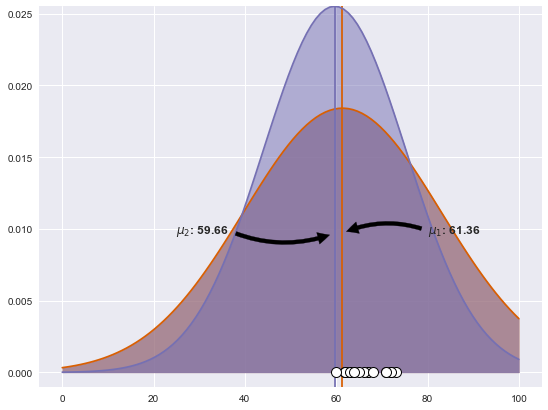

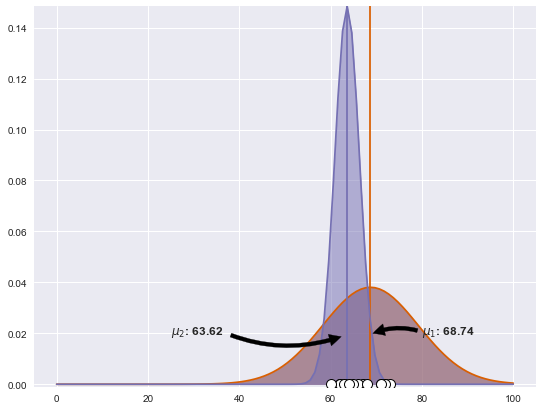

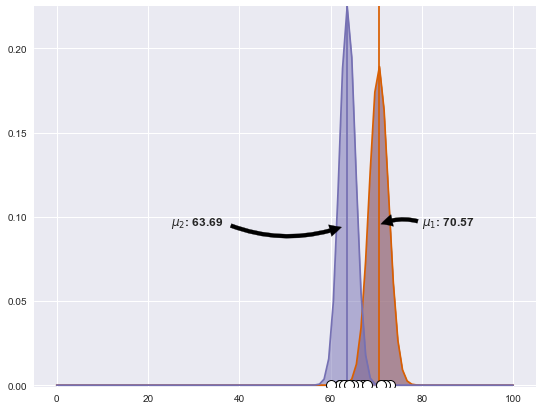

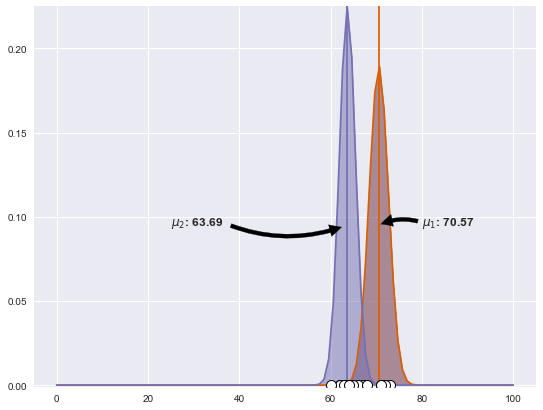

In [38]:
# In the below plots the white dots represent the observed heights.
ll, pis, mus, sigmas = em_gmm_orig(xs, pis, mus, sigmas)